In [1]:
from geoalchemy2 import Geometry, load_spatialite
from flask_caching import Cache
from sqlalchemy import event, Table, insert, func
from sqlalchemy.orm import sessionmaker
import os
from flask import Flask
from quickannotator.db import Project, Image, AnnotationClass, Notification, Tile, Setting, Annotation
from quickannotator.db import db
import large_image
import math
import numpy as np 
from shapely.geometry import Point, Polygon, LineString, MultiLineString, MultiPolygon
import random
from shapely.affinity import translate
import json
from tqdm import tqdm
import shapely
from shapely.geometry import shape
from api.v1.tile.helper import tiles_within_bbox
from api.v1.annotation.helper import count_annotations_within_bbox
import geojson

In [2]:
app = Flask("app")
SearchCache = Cache(config={'CACHE_TYPE': 'SimpleCache'})
SearchCache.init_app(app)
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///quickannotator.db'
os.environ['SPATIALITE_LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu/mod_spatialite.so'

db.app = app
db.init_app(app)
with app.app_context():
    event.listen(db.engine, 'connect', load_spatialite)

In [36]:
def insert_project(app, db, name, description, is_dataset_large):
    with app.app_context():
        project = Project(name=name,
                          description=description,
                          is_dataset_large=is_dataset_large)
        db.session.add(project)
        db.session.commit()
        
def insert_image(app, db, project_id, name, path, height, width, dz_tilesize, embedding_coord, group_id, split):
    with app.app_context():
        image = Image(project_id=project_id,
                      name=name,
                      path=path,
                      height=height,
                      width=width,
                      dz_tilesize=dz_tilesize,
                      embedding_coord=embedding_coord,
                      group_id=group_id,
                      split=split)
        db.session.add(image)
        db.session.commit()

def insert_image_by_path(app, db, project_id, full_path):
    slide = large_image.getTileSource(full_path)
    path = full_path.split("quickannotator/")[1]
    name = os.path.basename(full_path)
    
    with app.app_context():
        image = Image(project_id=project_id,
                      name=name,
                      path=path,
                      height=slide.sizeY,
                      width=slide.sizeX,
                      dz_tilesize=slide.tileWidth,
                      embedding_coord="POINT (1 1)",
                      group_id=0,
                      split=0
                      )
        
        db.session.add(image)
        db.session.commit()
    
def insert_annotation_class(app, db, project_id, name, color, magnification, patchsize, tilesize, dl_model_objectref):
    with app.app_context():
        annotation_class = AnnotationClass(project_id=project_id,
                                           name=name,
                                           color=color,
                                           magnification=magnification,
                                           patchsize=patchsize,
                                           tilesize=tilesize,
                                           dl_model_objectref=dl_model_objectref)
        db.session.add(annotation_class)
        db.session.commit()
              
def insert_tile(app, db, image_id, annotation_class_id, geom, seen):
    with app.app_context():
        tile = Tile(image_id=image_id,
                    annotation_class_id=annotation_class_id,
                    geom=geom,
                    seen=seen)
        
        db.session.add(tile)
        db.session.commit()
        
def insert_tiles(app, db, image_id, annotation_class_id):
    image_width, image_height = get_image_dimensions(app, image_id)
    
    with app.app_context():
        tile_size = AnnotationClass.query.filter_by(id=annotation_class_id).first().tilesize
    
    n_cols = math.ceil(image_width / tile_size)
    n_rows = math.ceil(image_height / tile_size)
    
    tiles = []
    for i in range(n_rows):
        for j in range(n_cols):
            t = Tile(image_id=image_id,
                     annotation_class_id=annotation_class_id,
                     geom=f"POLYGON(({j*tile_size} {i*tile_size}, {j*tile_size} {(i+1)*tile_size}, {(j+1)*tile_size} {(i+1)*tile_size}, {(j+1)*tile_size} {i*tile_size}, {j*tile_size} {i*tile_size}))",
                     seen=2
                     )
            tiles.append(t)
    with app.app_context():
        db.session.add_all(tiles)
        db.session.commit()
        

def annotations_within_bbox(app, db, table, x1, y1, x2, y2):
    envelope = func.BuildMbr(x1, y1, x2, y2)
    # Right now we are selecting by centroid and not polygon.
    with app.app_context():
        stmt = table.select().where(func.ST_Intersects(table.c.centroid, envelope))
        result = db.session.execute(stmt).fetchall()
        
    return result
  
def get_image_dimensions(app, image_id):
    with app.app_context():
        image = Image.query.filter_by(id=image_id).first()
        return image.width, image.height
        
def create_annotation_table(db, image_id, annotation_class_id, gtpred):
    table_name = f"{image_id}_{annotation_class_id}_{gtpred}_annotation"
    table = Annotation.__table__.to_metadata(db.metadata, name=table_name)
    db.metadata.create_all(bind=db.engine, tables=[table])
            
def generate_random_polygon(max_area=10, centroid=(0, 0)):
    num_points = random.randint(10, 20)  # Polygons need at least 3 points

    # Generate points in polar coordinates
    radii = np.sqrt(np.random.uniform(0, 1, num_points))  # Square root ensures uniform distribution
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

    # Convert polar coordinates to Cartesian coordinates
    points = [(r * np.cos(a), r * np.sin(a)) for r, a in zip(radii, angles)]

    # Sort points to form a simple polygon
    sorted_points = sorted(points, key=lambda p: np.arctan2(p[1], p[0]))

    # Create a Polygon and scale its area
    polygon = Polygon(sorted_points)

    # Calculate scaling factor
    current_area = polygon.area
    if current_area > 0:
        scaling_factor = np.sqrt(max_area / current_area)
        scaled_points = [(x * scaling_factor, y * scaling_factor) for x, y in sorted_points]
        polygon = Polygon(scaled_points)

    polygon = translate(polygon, xoff=centroid[0], yoff=centroid[1])

    return polygon
    
def generate_annotations(image_width, image_height, n_polygons):
    annotations = []
    for i in range(n_polygons):
        c = Point(np.random.randint(image_width), np.random.randint(image_height))
        
        poly: Polygon = generate_random_polygon(max_area=100000, centroid=(c.x, c.y))
        d = {
            "centroid": poly.centroid.wkt,  # Adding SRID=0 for pixel-based coordinates
            "area": poly.area,  # The area of the polygon
            "polygon": poly.wkt,  # Adding SRID=0 for the polygon
            "custom_metrics": json.dumps({"iou": 0.5})  # Convert custom_metrics to a JSON string
        }
        annotations.append(d)
        
    return annotations

def extract_annotations_from_geojson_file(filepath):
    with open('/home/jackson/research/data/13_266069_040_003 L02 PAS.json', 'r') as file:
        # Load the JSON data into a Python dictionary
        data = json.load(file)
    
    annotations = []
    for i, d in enumerate(tqdm(data)):
        shapely_geometry = shape(d['geometry'])
        annotation = {
            "centroid": shapely_geometry.centroid.wkt,
            "area": shapely_geometry.area,
            "polygon": shapely_geometry.wkt,
            "custom_metrics": json.dumps({"iou": 0.5}) 
        }
        
        annotations.append(annotation)
        
    return annotations

def insert_annotations(app, db, image_id, annotation_class_id, gtpred, n):
    table_name = f"{image_id}_{annotation_class_id}_{gtpred}_annotation"

    
    with app.app_context():
        table = Table(table_name, db.metadata, autoload_with=db.engine)
        image = db.session.query(Image).filter_by(id=image_id).first()
        annotations = generate_annotations(image.width, image.height, n)
        
        stmt = insert(table).values(annotations)
        db.session.execute(stmt)
        db.session.commit()
        
def insert_existing_annotations(app, db, image_id, annotation_class_id, gtpred, filepath):
    with open(filepath, 'r') as file:
        # Load the JSON data into a Python dictionary
        data = json.load(file)
    all_anno = []
    
    table_name = f"{image_id}_{annotation_class_id}_{gtpred}_annotation"
    
    
    for i, d in enumerate(tqdm(data)):
        if d['properties']['classification']['name'] == 'tubule':
            shapely_geometry = shape(d['geometry'])
            annotation = {
                "centroid": shapely_geometry.centroid.wkt,
                "area": shapely_geometry.area,
                "polygon": shapely_geometry.wkt,
                "custom_metrics": json.dumps({"iou": 0.5}) 
            }
            
            all_anno.append(annotation)
        if len(all_anno)==1_000:
            with app.app_context():
                table = Table(table_name, db.metadata, autoload_with=db.engine)
                stmt = insert(table).values(all_anno)
                db.session.execute(stmt)
                db.session.commit()
            all_anno = []
    
    # commit any remaining annotations
    with app.app_context():
        table = Table(table_name, db.metadata, autoload_with=db.engine)
        stmt = insert(table).values(all_anno)
        db.session.execute(stmt)
        db.session.commit()
            
def insert_qupath_geojson_file(app, db, image_id, annotation_class_id, gtpred, filepath):
    '''
    This is expected to be a geojson feature collection file, with each polygon being a feature.
    
    '''
    with open(filepath, 'r') as file:
        # Load the JSON data into a Python dictionary
        data = json.load(file)["features"]
    all_anno = []
    
    table_name = f"{image_id}_{annotation_class_id}_{gtpred}_annotation"
    
    
    for i, d in enumerate(tqdm(data)):

        shapely_geometry = shape(d['geometry'])
        annotation = {
            "centroid": shapely_geometry.centroid.wkt,
            "area": shapely_geometry.area,
            "polygon": shapely_geometry.wkt,
            "custom_metrics": json.dumps({"iou": 0.5}) 
        }
        
        all_anno.append(annotation)
        
        if len(all_anno)==1_000:
            with app.app_context():
                table = Table(table_name, db.metadata, autoload_with=db.engine)
                stmt = insert(table).values(all_anno)
                db.session.execute(stmt)
                db.session.commit()
            all_anno = []
    
    # commit any remaining annotations
    with app.app_context():
        table = Table(table_name, db.metadata, autoload_with=db.engine)
        stmt = insert(table).values(all_anno)
        db.session.execute(stmt)
        db.session.commit()

insert_qupath_geojson_file(app, db,
                            image_id=1,
                            annotation_class_id=1,
                            gtpred='gt',
                            filepath='/home/jackson/research/data/test_ndpi/13_266069_040_003 L02 PAS_tissue_mask.geojson')


100%|██████████| 3/3 [00:00<00:00, 1072.35it/s]


In [43]:
with app.app_context():
    result = tiles_within_bbox(db, 1, 2, 0, 0, 60000, 60000)
    
print(result)

[<Tile 249>, <Tile 250>, <Tile 322>, <Tile 323>, <Tile 324>, <Tile 396>, <Tile 397>, <Tile 398>, <Tile 469>, <Tile 470>, <Tile 471>, <Tile 472>, <Tile 542>, <Tile 543>, <Tile 544>, <Tile 545>, <Tile 546>, <Tile 614>, <Tile 615>, <Tile 616>, <Tile 617>, <Tile 618>, <Tile 619>, <Tile 688>, <Tile 689>, <Tile 690>, <Tile 691>, <Tile 692>, <Tile 761>, <Tile 762>, <Tile 763>, <Tile 764>, <Tile 766>, <Tile 767>, <Tile 768>, <Tile 834>, <Tile 835>, <Tile 836>, <Tile 837>, <Tile 839>, <Tile 840>, <Tile 841>, <Tile 842>, <Tile 905>, <Tile 906>, <Tile 907>, <Tile 908>, <Tile 909>, <Tile 910>, <Tile 911>, <Tile 912>, <Tile 913>, <Tile 914>, <Tile 915>, <Tile 916>, <Tile 978>, <Tile 979>, <Tile 980>, <Tile 981>, <Tile 982>, <Tile 983>, <Tile 984>, <Tile 985>, <Tile 986>, <Tile 987>, <Tile 988>, <Tile 989>, <Tile 1051>, <Tile 1052>, <Tile 1053>, <Tile 1054>, <Tile 1055>, <Tile 1056>, <Tile 1058>, <Tile 1059>, <Tile 1060>, <Tile 1061>, <Tile 1062>, <Tile 1123>, <Tile 1124>, <Tile 1125>, <Tile 1126>, 

In [21]:
with app.app_context():
    table_name = '1_2_gt_annotation'
    table = Table(table_name, db.metadata, autoload_with=db.engine)
    
    annotations = count_annotations_within_bbox(table, 30000,30000,60000,60000)

In [22]:
annotations

1231

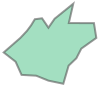

In [14]:
generate_random_polygon(max_area=10, centroid=(0, 0))

In [15]:
generate_annotations(1000, 1000, 1)

[{'centroid': 'POINT (60.56744754485924 234.89904734669702)',
  'area': 100000.00000000001,
  'polygon': 'POLYGON ((-72.08890719140521 158.5698053560821, -113.5938061481846 14.316090686223134, 78.78331263237743 154.60332634379932, 126.36578731038618 -50.08475816773961, 117.63356929391533 168.65836404558516, 295.2101034486657 95.4464722180461, 263.4301289835106 200, 239.90057969718603 275.52485038032216, 232.85238858415886 398.2649133956455, 113.52048238944744 344.29415435734165, 10.748356095898089 424.7901105672206, -61.24533860300218 339.3072139380438, -191.33667891903093 270.82213059066834, -72.08890719140521 158.5698053560821))',
  'custom_metrics': '{"iou": 0.5}'}]

In [24]:
models = [Project, Image, AnnotationClass, Notification, Tile, Setting]
with app.app_context():
    db.metadata.create_all(bind=db.engine, tables=[item.__table__ for item in models])
    create_annotation_table(db, 1, 1, "gt")
    create_annotation_table(db, 1, 2, "gt")
    create_annotation_table(db, 2, 1, "gt")
    create_annotation_table(db, 2, 2, "gt")
    

updateTableTriggers: "table "idx_tile_geom" already exists"
/tmp/ipykernel_192564/3585515477.py:111: SAWarning: Table 'annotation' already exists within the given MetaData - not copying.
  table = Annotation.__table__.to_metadata(db.metadata, name=table_name)


In [17]:
insert_project(app, db, 
               name="example_project", 
               description="test", 
               is_dataset_large=False)

insert_image_by_path(app, db,
                     project_id=1,
                     full_path="/home/jackson/research/code/HistoTools/QA_jackson/quickannotator/data/mnts/FSGS/13_266069_040_003 L02 PAS.ndpi"
                     )

insert_image_by_path(app, db,
                     project_id=1,
                     full_path="/home/jackson/research/code/HistoTools/QA_jackson/quickannotator/data/images/1/TCGA-23-2072-01Z-00-DX1.478243FF-BFF0-48A4-ADEA-DE789331A50E.svs")

insert_annotation_class(app, db,
                        project_id=None,
                        name="Tissue Mask",
                        color="black",
                        magnification=None,
                        patchsize=None,
                        tilesize=None,
                        dl_model_objectref=None)

insert_annotation_class(app, db,
                        project_id=1,
                        name="Tubule",
                        color="red",
                        magnification=10,
                        patchsize=256,
                        tilesize=2048,
                        dl_model_objectref=None)

insert_tiles(app, db, image_id=1, annotation_class_id=2)

insert_tiles(app, db, image_id=2, annotation_class_id=2)

insert_annotations(app, db, image_id=2, annotation_class_id=2, gtpred="gt", n=10000)

insert_existing_annotations(app, db,
                            image_id=1,
                            annotation_class_id=2,
                            gtpred="gt",
                            filepath='/home/jackson/research/data/test_ndpi/13_266069_040_003 L02 PAS.json'
                            )


insert_qupath_geojson_file(app, db,
                            image_id=1,
                            annotation_class_id=1,
                            gtpred='gt',
                            filepath='/home/jackson/research/data/test_ndpi/13_266069_040_003 L02 PAS_tissue_mask.geojson')

100%|██████████| 88605/88605 [00:04<00:00, 17995.35it/s]


In [26]:
insert_tiles(app, db, image_id=2, annotation_class_id=2)

In [19]:
# insert_annotations(app, db, image_id=1, annotation_class_id=2, gtpred="gt", n=10000)

In [20]:
with app.app_context():
    table_name = '1_2_gt_annotation'
    table = Table(table_name, db.metadata, autoload_with=db.engine)
    anns = annotations_within_bbox(app, db, table, 0,0,5000,5000)

In [21]:
anns

[]

In [22]:
get_image_dimensions(app, 1)

(150784, 71936)